# Spectral Line Data Cubes in Astronomy - Part 2 (unfinished)

We are doing a complete re-analysis of the same NGC 6503 case, but now with more tools that the community has developed. For this you will need to modify your python environment.

See also http://adsabs.harvard.edu/abs/2015ASPC..499..363G for the paper describing this project.


In [1]:
%matplotlib inline

## Reading the data

Two new community modules are introduced here: *spectral_cube* and *radio_beam*, both from the https://github.com/radio-astro-tools project.

### Manual

    git clone https://github.com/radio-astro-tools/spectral_cube
    cd spectral_cube
    python setup.py install
    
    git clone https://github.com/radio-astro-tools/radio_beam
    cd radio_beam
    python setup.py install

### Automated

You can also simply use the **pip** command from the dos/unix shell to install it:

    pip install spectral-cube radio-beam
    
   Note the underscore and dash convention.
 

In [2]:
import numpy as np
import astropy.units as u
from spectral_cube import SpectralCube
import radio_beam

In [3]:
cube = SpectralCube.read('ngc6503.cube.fits')
print(cube)

SpectralCube with shape=(89, 251, 371) and unit=Jy / beam:
 n_x:    371  type_x: RA---SIN  unit_x: deg    range:   266.676861 deg:  267.895600 deg
 n_y:    251  type_y: DEC--SIN  unit_y: deg    range:    70.007750 deg:   70.285758 deg
 n_s:     89  type_s: FREQ      unit_s: Hz     range: 1419177268.848 Hz:1421325706.348 Hz


To suppress some future warnings, we tell spectral-cube that it's OK to do large operations:
(see https://spectral-cube.readthedocs.io/en/latest/errors.html#silencing-warnings)

In [4]:
import warnings
from spectral_cube.utils import SpectralCubeWarning
warnings.simplefilter('ignore',
                      category=SpectralCubeWarning,
                      append=True)

A FITS file consists of a series of Header-Data-Units (HDU). Usually there is only one, representing the image. But this file has two. For now, we're going to ignore the second, which is a special table and in this example happens to be empty anyways.  Each HDU has a header, and data.  The data in this case is a numpy array, and represents the image (cube):

In [5]:
h = cube.header
d = cube
print(d.shape, d.min(), d.max(), d.mean(), np.median(d), d.std())
print("Signal/Noise  (S/N):",d.max()/d.std())

(89, 251, 371) -0.003157205879688263 Jy / beam 0.016983529552817345 Jy / beam 4.734359390567988e-05 Jy / beam 1.3375308e-05 0.0007403538911603391 Jy / beam
Signal/Noise  (S/N): 22.93974494934082


From the shape (89,251,371) we can see this image is already 3 dimensional, the dummy 4th dimension we saw in the previous example is not present here. There are 371 pixels along X, 251 along Y, and 89 slices or spectral channels. 

In case you were wondering about that missing 4th redundant axis. This an intentional simplification of the data model in spectral-cube in which the degenerate (size 1) Stokes dimension is dropped.  You can see a warning about that above.

The material below this should be the same as the previous "case1" notebook (even though the data array is not exactly just a numpy array, but a ``SpectralCube``!)

## Plotting some basics

In [6]:
import matplotlib.pyplot as plt

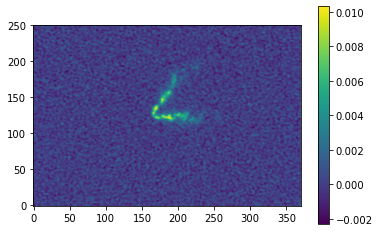

In [7]:
z = 35
im = d[z,:,:]                              #   im = d[z]     also works
plt.imshow(im.value, origin='lower')
plt.colorbar()

There are 89 channels (slices) in this cube, numbered 0 through 88 in the usual python sense. Pick a few other slices by changing the value in 
**z=** and notice that the first few and last few appear to be just noise and that the V-shaped signal changes shape through the channels. Perhaps you should not be surprised that these are referred to as butterfly diagrams.

8287769


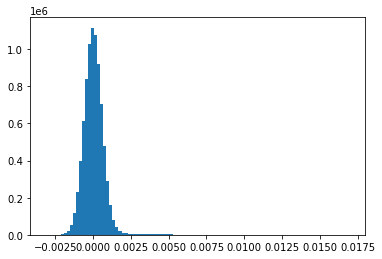

In [8]:
# look at a histogram of all the data (histogram needs a 1D array, so we use the "flattened" (1D) view of the cube)
d1 = cube.flattened()
print(cube.size)
(n,b,p) = plt.hist(d1.value, bins=100)

Notice that the histogram is on the left in the plot, and we already saw the maximum data point is 0.0169835.

So let us plot the vertical axis logarithmically, so we can better see what is going on.

In [9]:
# this lets us use Quantity's in matplotlib plots directly
from astropy.visualization import quantity_support

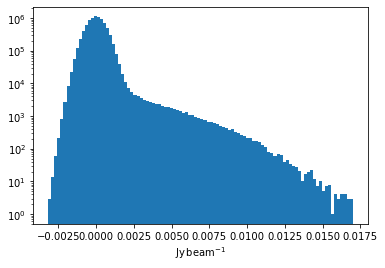

In [10]:
with quantity_support():
    (n,b,p) = plt.hist(d1,bins=100,log=True)

-1.2134018e-06 0.00055829244


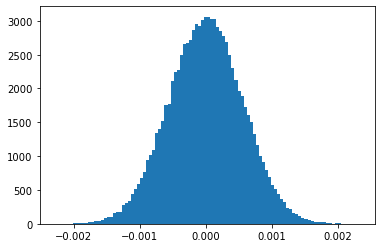

In [11]:
# pick a slice and make a histogram and print the mean and standard deviation of the signal in that slice
z=0
imz = d[z,:,:].value.ravel()
(n,b,p) = plt.hist(imz,bins=100)
print(imz.mean(), imz.std())

**Exercise** : observe by picking some values of **z** that the noise seems to vary a little bit from one end of the band to the other.  Store the noise in channel 0 and 88 in variables sigma0 and sigma88:


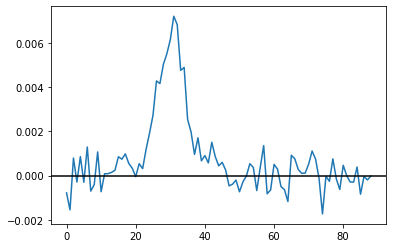

In [12]:
xpeak = 175
ypeak = 125
channel = np.arange(d.shape[0])
spectrum = d[:,ypeak,xpeak]
plt.plot(channel,spectrum)
plt.axhline(0, color='k')

You can also plot the spectrum against the frequency

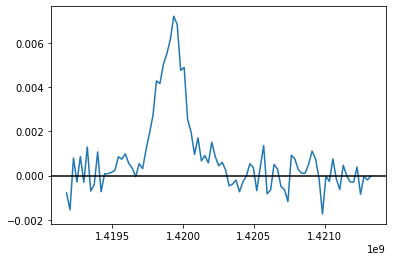

In [13]:
xpeak = 175
ypeak = 125
spectrum = d[:,ypeak,xpeak]
plt.plot(cube.spectral_axis, spectrum)
plt.axhline(0, color='k')

In [14]:
sigma0 = 0.00056 * cube.unit
sigma88 = 0.00059 * cube.unit

## Smoothing a cube to enhance the signal to noise

In [15]:
slc = d[z]

In [16]:
cube.beam

Beam: BMAJ=14.413319999999999 arcsec BMIN=13.333680000000001 arcsec BPA=-88.86 deg

In [17]:
from radio_beam import Beam

(251, 371) -1.149398840663908e-06 Jy / beam 0.00012159715074647426 Jy / beam


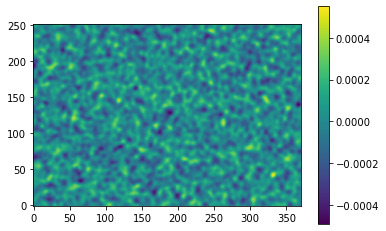

In [18]:
z = 0
target_beam = Beam(30*u.arcsec)
ds1 = d[z].convolve_to(target_beam)
print(ds1.shape, ds1.mean(), ds1.std())
plt.imshow(ds1.value, origin='lower')
plt.colorbar()

Notice that the noise is indeed lower than your earlier value of sigma0.   We only smoothed one single slice, but we actually need to smooth the whole cube.  This can be done with `cube.convolve_to`. 

0.011834807713019146 Jy / beam 97.32800185173993


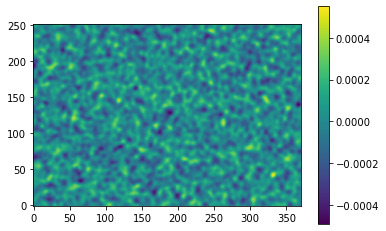

In [19]:
ds = cube.convolve_to(target_beam)
plt.imshow(ds[z].value, origin='lower')
plt.colorbar()
print(ds.max(),ds.max()/ds1.std())

Notice that, although the peak value was lowered a bit due to the smoothing, the signal to noise has increased from the original cube. So, the signal should stand out a lot better.

**Exercise** : Observe a subtle difference in the last two plots. Can you see what happened here?

## Masking


This masking selection includes only pixels with signal >2-sigma:

In [20]:
nsigma = 3.0
masked_cube = cube.with_mask((cube > sigma0*nsigma))
print(f"The mask includes {masked_cube.mask.include().sum()} pixels and excludes {masked_cube.mask.exclude().sum()}")

The mask includes 99274 pixels and excludes 8188495


PEAK at location: 148 113 0


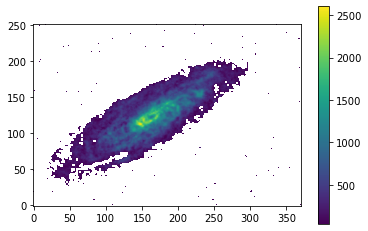

In [21]:
mom0 = masked_cube.moment0()
plt.imshow(mom0.value,origin='lower')
plt.colorbar()
(ypeak,xpeak) = np.unravel_index(np.nanargmax(mom0), mom0.shape)
print("PEAK at location:",xpeak,ypeak,mom0.argmax())

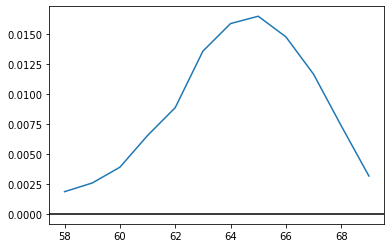

In [22]:
spectrum2 = masked_cube[:,ypeak,xpeak]
plt.plot(channel,spectrum2)
plt.axhline(0, color='k')

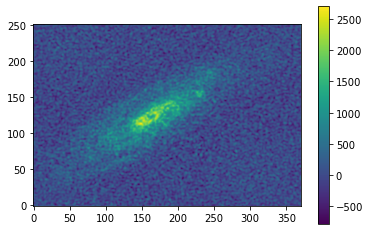

In [23]:
mom0s = cube.moment0()
plt.imshow(mom0s.value,origin='lower')
plt.colorbar()

## Velocity fields

The mean velocity is defined a the first moment

$$
<V> = {\Sigma{(v.I)} \over \Sigma{(I)} }
$$

MINMAX -1555901.0731934109 km / s 4756984.485698268 km / s


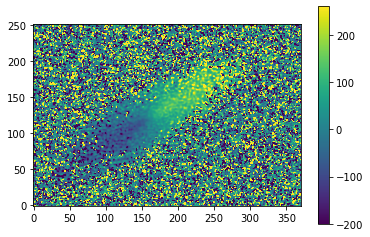

In [24]:
velocity_cube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')
vmean = velocity_cube.moment1()
print("MINMAX",np.nanmin(vmean),np.nanmax(vmean))
plt.imshow(vmean.value,origin='lower', vmin=-200, vmax=260)
plt.colorbar()

This is very noisy!

Let's see how the smooth cube looks:

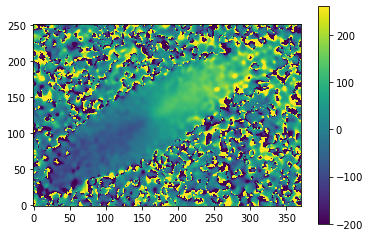

In [25]:
vmean_smooth = ds.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment1()
plt.imshow(vmean_smooth.value, origin='lower', vmin=-200, vmax=260)
plt.colorbar()

Although more coherent, there are still bogus values outside the image of the galaxy. So we will define areas in the cube where the signal to noise is high enough to give a good answer.

/Users/adam/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


MINMAX -194.16661379785586 km / s 259.28505526041977 km / s


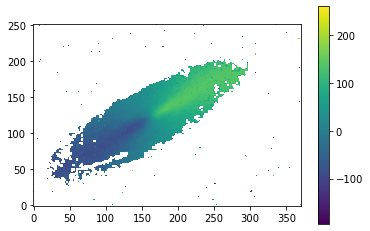

In [26]:
masked_velocity_cube = masked_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')
vmean = masked_velocity_cube.moment1()
print("MINMAX",np.nanmin(vmean),np.nanmax(vmean))
plt.imshow(vmean.value,origin='lower')
plt.colorbar()

And voila, now this looks a lot better.